In [1]:
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import medmnist
from medmnist import INFO

In [2]:
data_flag = "pneumoniamnist"
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [31]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, root="../data/")
valid_dataset = DataClass(split='val', transform=data_transform, download=download, root="../data/")
test_dataset = DataClass(split='test', transform=data_transform, download=download, root="../data/")

BATCH_SIZE = 128
# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: ../data/pneumoniamnist.npz
Using downloaded and verified file: ../data/pneumoniamnist.npz
Using downloaded and verified file: ../data/pneumoniamnist.npz


In [32]:
img_batch, label_batch = next(iter(train_loader))

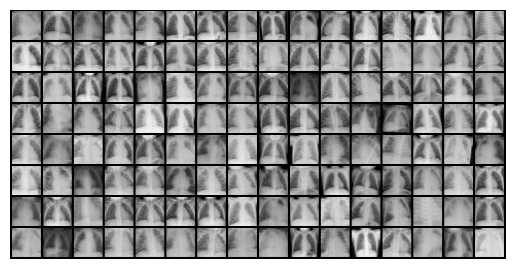

In [33]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

plt.imshow(make_grid(img_batch, nrow=16).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
from src.model import VAE, SimpleCNNClassifier
from src.trainer import CDVAETrainer, SimpleCNNTrainer
from src.model import interpolate_latent

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
cnn = SimpleCNNClassifier(n_class=2).to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = SimpleCNNTrainer(cnn, optimizer, criterion, 5, device)

In [37]:
trainer.fit(11, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 5/5 [00:00<00:00, 163.46it/s]


val_aupr: {0: 0.952, 1: 0.994}
0.973
val_auroc: {0: 0.982, 1: 0.982}
0.982


val-epoch 5: 100%|██████████| 5/5 [00:00<00:00, 192.32it/s]


val_aupr: {0: 0.983, 1: 0.998}
0.99
val_auroc: {0: 0.994, 1: 0.994}
0.994


val-epoch 10: 100%|██████████| 5/5 [00:00<00:00, 178.58it/s]

val_aupr: {0: 0.983, 1: 0.998}
0.99
val_auroc: {0: 0.994, 1: 0.994}
0.994


In [38]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 5/5 [00:00<00:00, 161.32it/s]

val_aupr: {0: 0.935, 1: 0.955}
0.945
val_auroc: {0: 0.944, 1: 0.944}
0.944


In [73]:
Z_DIM = 32
TEMP = 0.5
ALPHA = [1000, 1000]
LABEL_FLIPPING = True
vae = VAE(total_z_dim=Z_DIM).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 0.5, "loc": 5e3, "scale": 1e3,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [74]:
trainer.fit(51, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 5/5 [00:00<00:00, 111.11it/s]


val_recontr_loss=20.979, val_kl_c=2.035, val_kl_s=1.216, val_c_loss=0.294, val_s_loss=1.119
gMIG: 0.3


val-epoch 5: 100%|██████████| 5/5 [00:00<00:00, 124.98it/s]


val_recontr_loss=6.928, val_kl_c=3.466, val_kl_s=8.805, val_c_loss=0.168, val_s_loss=1.019
gMIG: 0.361


val-epoch 10: 100%|██████████| 5/5 [00:00<00:00, 116.28it/s]


val_recontr_loss=5.645, val_kl_c=4.053, val_kl_s=9.481, val_c_loss=0.157, val_s_loss=1.008
gMIG: 0.38


val-epoch 15: 100%|██████████| 5/5 [00:00<00:00, 122.18it/s]


val_recontr_loss=4.515, val_kl_c=4.539, val_kl_s=9.365, val_c_loss=0.126, val_s_loss=1.014
gMIG: 0.393


val-epoch 20: 100%|██████████| 5/5 [00:00<00:00, 119.05it/s]


val_recontr_loss=4.235, val_kl_c=5.318, val_kl_s=8.400, val_c_loss=0.136, val_s_loss=1.000
gMIG: 0.43


val-epoch 25: 100%|██████████| 5/5 [00:00<00:00, 116.30it/s]


val_recontr_loss=4.189, val_kl_c=6.194, val_kl_s=6.928, val_c_loss=0.158, val_s_loss=0.999
gMIG: 0.384


val-epoch 30: 100%|██████████| 5/5 [00:00<00:00, 116.28it/s]


val_recontr_loss=3.784, val_kl_c=6.079, val_kl_s=8.044, val_c_loss=0.142, val_s_loss=1.002
gMIG: 0.395


val-epoch 35: 100%|██████████| 5/5 [00:00<00:00, 125.01it/s]


val_recontr_loss=3.622, val_kl_c=6.165, val_kl_s=7.584, val_c_loss=0.160, val_s_loss=0.998
gMIG: 0.401


val-epoch 40: 100%|██████████| 5/5 [00:00<00:00, 116.26it/s]


val_recontr_loss=3.620, val_kl_c=6.177, val_kl_s=7.858, val_c_loss=0.127, val_s_loss=0.996
gMIG: 0.41


val-epoch 45: 100%|██████████| 5/5 [00:00<00:00, 113.58it/s]


val_recontr_loss=3.577, val_kl_c=6.136, val_kl_s=7.827, val_c_loss=0.133, val_s_loss=0.996
gMIG: 0.436


val-epoch 50: 100%|██████████| 5/5 [00:00<00:00, 119.05it/s]


val_recontr_loss=3.511, val_kl_c=6.122, val_kl_s=7.519, val_c_loss=0.129, val_s_loss=0.995
gMIG: 0.434


In [66]:
mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label in tqdm(train_loader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

100%|██████████| 37/37 [00:00<00:00, 135.55it/s]


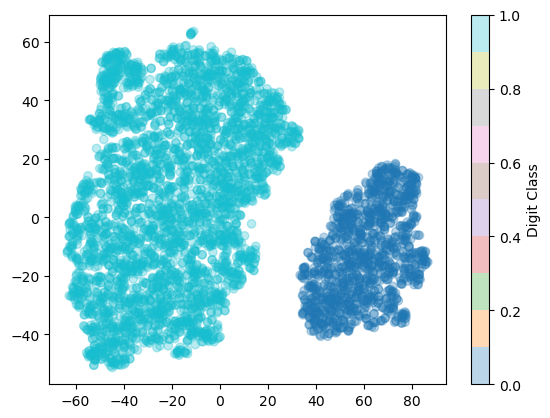

In [67]:
plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [68]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

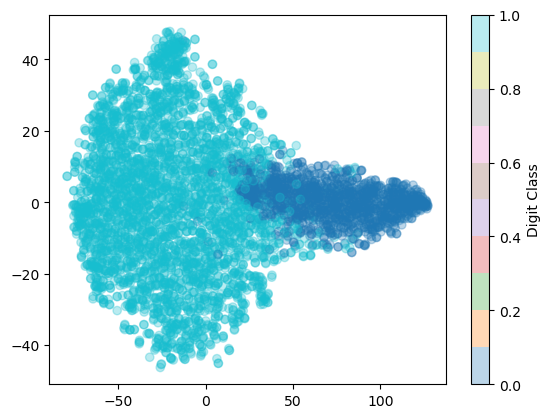

In [69]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [70]:
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [71]:
from src.trainer import DownstreamMLPTrainer
mlp = torch.nn.Sequential(
    torch.nn.Linear(16, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = DownstreamMLPTrainer(vae, mlp, optimizer, criterion, 10, device)
trainer.fit(41, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 5/5 [00:00<00:00, 158.77it/s]


val_aupr: {0: 0.974, 1: 0.992}
0.983
val_auroc: {0: 0.99, 1: 0.977}
0.984


val-epoch 10: 100%|██████████| 5/5 [00:00<00:00, 172.28it/s]


val_aupr: {0: 0.975, 1: 0.996}
0.986
val_auroc: {0: 0.989, 1: 0.988}
0.988


val-epoch 20: 100%|██████████| 5/5 [00:00<00:00, 185.19it/s]


val_aupr: {0: 0.975, 1: 0.995}
0.985
val_auroc: {0: 0.989, 1: 0.988}
0.988


val-epoch 30: 100%|██████████| 5/5 [00:00<00:00, 160.72it/s]


val_aupr: {0: 0.975, 1: 0.995}
0.985
val_auroc: {0: 0.989, 1: 0.988}
0.988


val-epoch 40: 100%|██████████| 5/5 [00:00<00:00, 166.67it/s]

val_aupr: {0: 0.975, 1: 0.996}
0.986
val_auroc: {0: 0.989, 1: 0.989}
0.989


In [72]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 5/5 [00:00<00:00, 155.43it/s]

val_aupr: {0: 0.907, 1: 0.9}
0.904
val_auroc: {0: 0.912, 1: 0.902}
0.907
